### Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense , GRU , SimpleRNN
from prophet import Prophet
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# We will just deal with hourly predictions, so we'll sub-sampling the data from 10-minute intervals to one-hour intervals:

df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
df_t = df[["T (degC)"]]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

13568290/13568290 [==============================] - 0s 0us/step


## Splitting of Data in 70:20:10 for ( training , validation , testing ) sets

In [ ]:
# The result is a dictionary, column_indices, where the keys are the column names of df, and the values are their respective indices in the column list.
# This dictionary can be used to quickly access the index of a column based on its name, which can be useful for various oprs such as column rearrangement,selec. or manip.
column_indices = {name: i for i, name in enumerate(df_t.columns)}

n = len(df_t)
train_df = df_t[0:int(n*(70/100))]
val_df = df_t[int(n*(70/100)):int(n*(90/100))]
test_df = df_t[int(n*(90/100)):]

num_features = df_t.shape[1]
# print(num_features)

## Normalize the data

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.size

49063

### Adding Date of datetime type as prophet required

In [ ]:
train_df['ds'] = date_time[:int(n*(70/100))]
val_df['ds'] = date_time[int(n*(70/100)):int(n*(90/100))]
test_df['ds'] = date_time[int(n*(90/100)):]

In [ ]:
train_df = train_df.rename(columns = {'T (degC)' : 'y'} )
val_df = val_df.rename(columns = {'T (degC)' : 'y'} )
test_df = test_df.rename(columns = {'T (degC)' : 'y'} )

In [ ]:
train_df.head()

,y,ds
5,-1.982473,2009-01-01 01:00:00
11,-2.078372,2009-01-01 02:00:00
17,-2.070284,2009-01-01 03:00:00
23,-2.098014,2009-01-01 04:00:00
29,-2.165028,2009-01-01 05:00:00


### visualizing the data

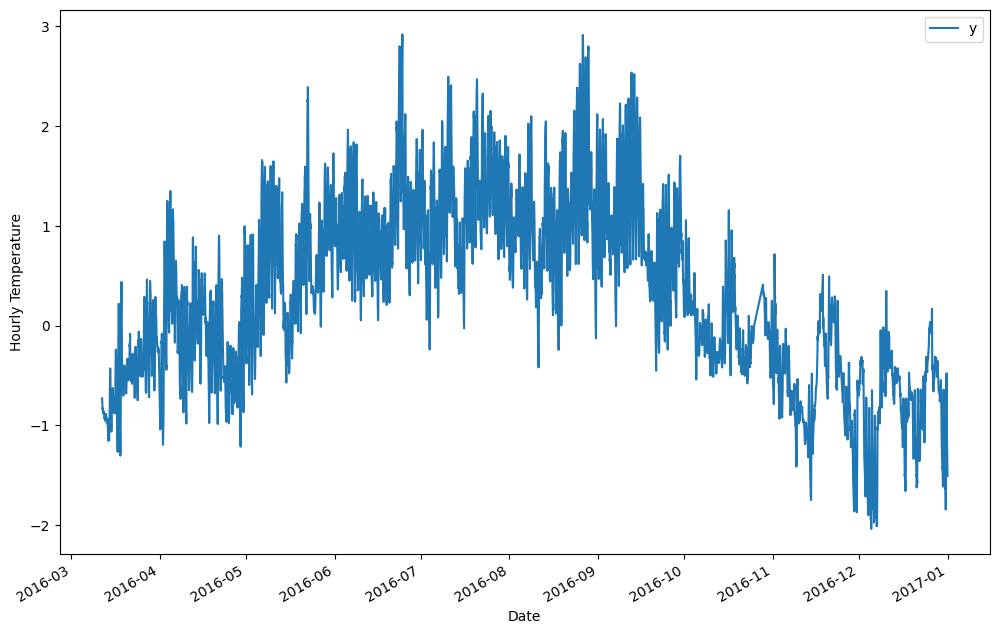

In [ ]:
ax = test_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Hourly Temperature')
ax.set_xlabel('Date')

plt.show()

## Prophet

In [ ]:
prophet = Prophet(interval_width = 0.95)

In [ ]:
prophet.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpml9kqzae/29el7y_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpml9kqzae/r_4wnaqt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99351', 'data', 'file=/tmp/tmpml9kqzae/29el7y_p.json', 'init=/tmp/tmpml9kqzae/r_4wnaqt.json', 'output', 'file=/tmp/tmpml9kqzae/prophet_modelk7wxa97m/prophet_model-20230705171402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_dates = prophet.make_future_dataframe(periods=24, freq='MS')

# instructed prophet to create 24 datestamps into future
# we are looking to predict future values of our time series 24 hours into the future.

future_dates.head()

,ds
0,2009-01-01 01:00:00
1,2009-01-01 02:00:00
2,2009-01-01 03:00:00
3,2009-01-01 04:00:00
4,2009-01-01 05:00:00


In [ ]:
forecast = prophet.predict(future_dates)

In [ ]:
mse = mean_squared_error(train_df['y'] , forecast['yhat'])
mae = mean_absolute_error(train_df['y'] , forecast['yhat'])
mape = mean_absolute_percentage_error(train_df['y'] , forecast['yhat'])

In [ ]:
mape

3.066705124781289

## Plot

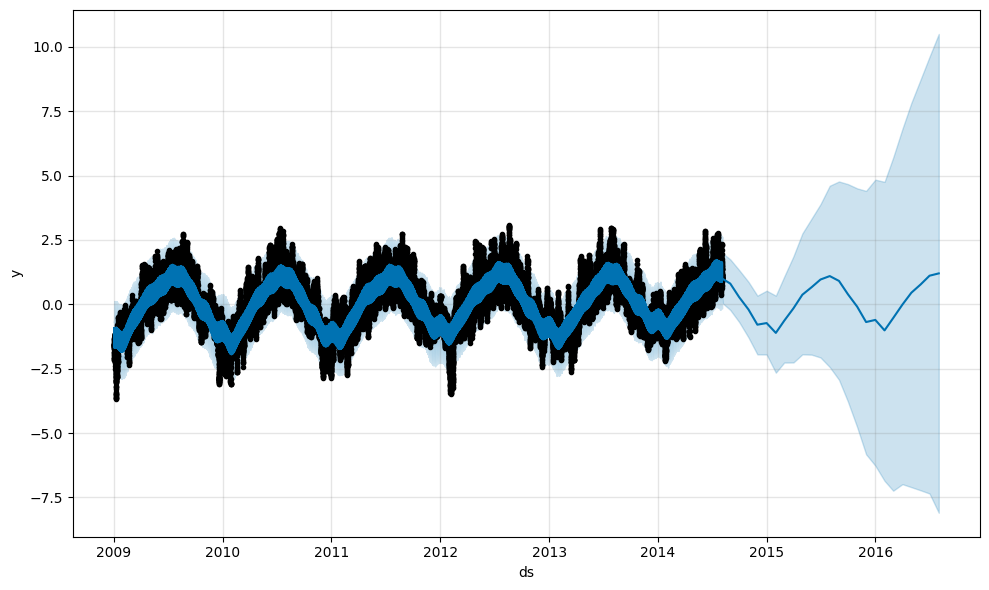

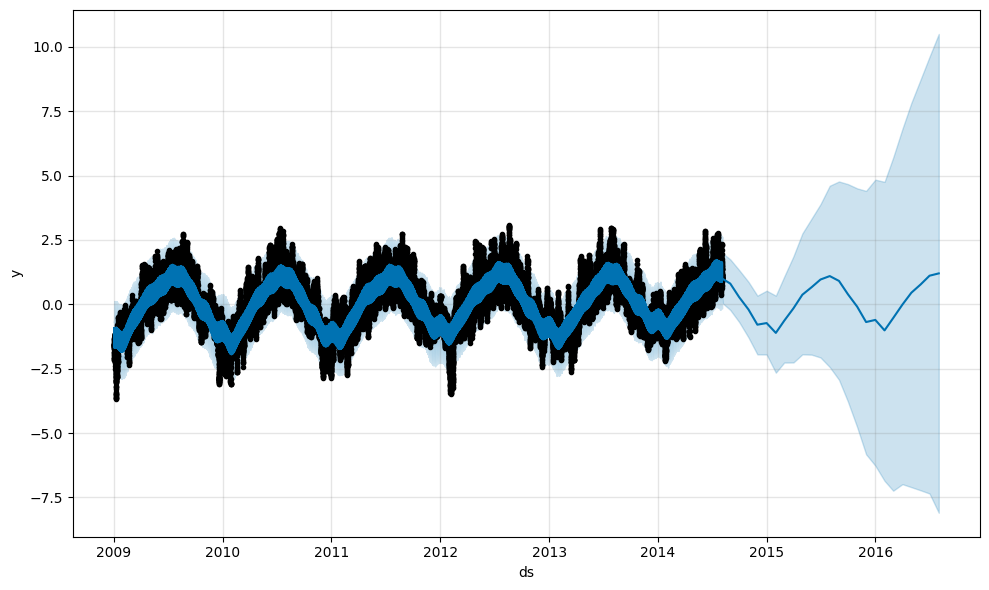

In [ ]:
prophet.plot(forecast, uncertainty=True)
# observed values of our time series (the black dots),
# the forecasted values (blue line) ,
# uncertainty intervals of our forecasts (the blue shaded regions).

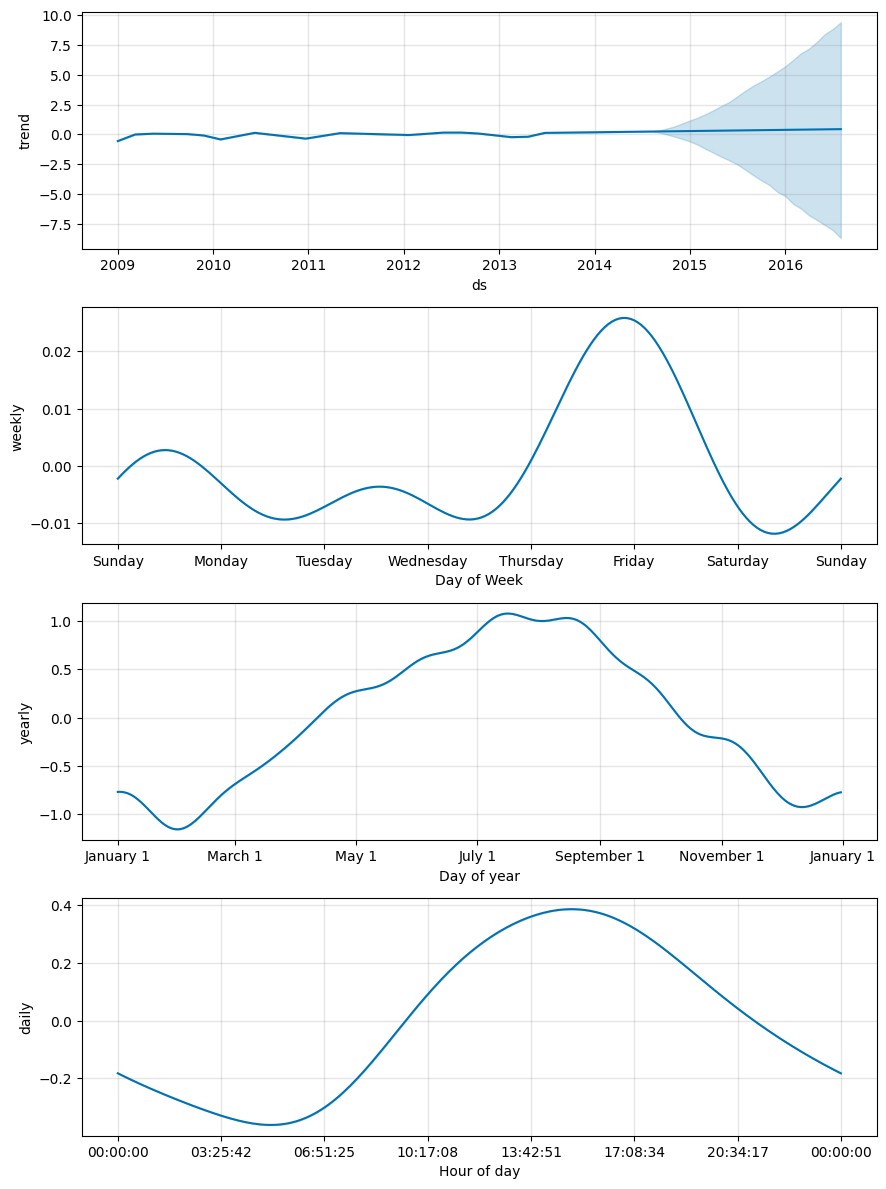

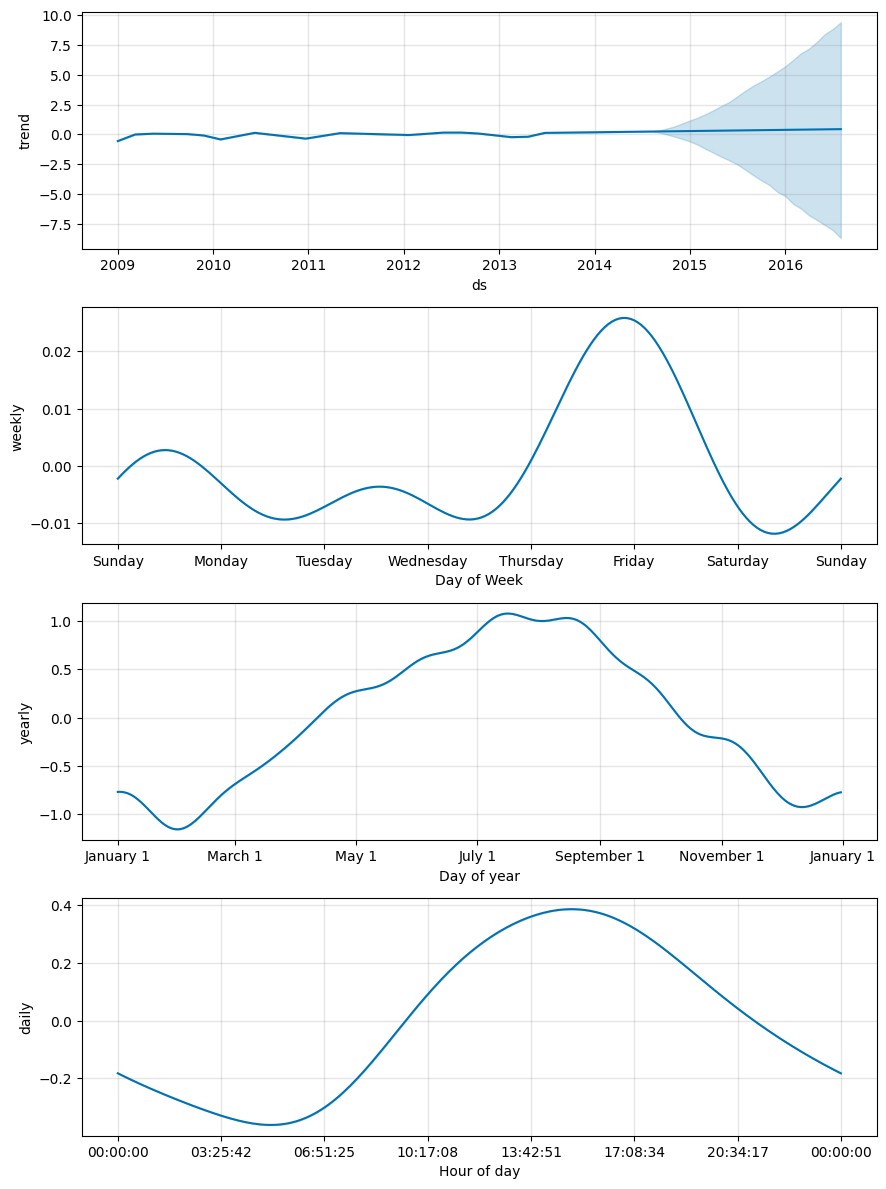

In [ ]:
prophet.plot_components(forecast)
# This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.
